# Using two spatial weights matrices

Some functions are using spatial weights for two different purposes. Therefore two matrices have to be passed. We will illustrate this case measuring building adjacency and mean interbuilding distance. 

In [2]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

/Users/martin/Git/momepy/momepy/coins.py:15: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/martin/mambaforge/envs/momepy_dev/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .a

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation. 

In [3]:
import osmnx as ox

gdf = ox.geometries.geometries_from_place('Kahla, Germany', tags={'building':True})
buildings = ox.projection.project_gdf(gdf)

buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit,
                                   verbose=False).tessellation

/Users/martin/mambaforge/envs/momepy_dev/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/martin/mambaforge/envs/momepy_dev/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/martin/mambaforge/envs/momepy_dev/lib/python3.11/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/martin/mambaforge/envs/momepy_dev/lib/python3.11/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/martin/mambaforge/envs/momepy_dev/lib/python3.11/site-packages/pygeos/predicates.py:764: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/martin/mambaforge/envs/momepy_dev/lib

## Building adjacency

Building adjacency is using `spatial_weights_higher` to denote the area within which the calculation occurs (required) and `spatial_weights` to denote adjacency of buildings (optional, the function can do it for us). We can use distance band of 200 meters to define `spatial_weights_higher`.

In [4]:
import libpysal
dist200 = libpysal.weights.DistanceBand.from_dataframe(buildings, 200,
                                                       ids='uID')

/Users/martin/mambaforge/envs/momepy_dev/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 7 disconnected components.
 There are 3 islands with ids: 329, 577, 2491.
  warnings.warn(message)


In [4]:
adjac = momepy.BuildingAdjacency(
    buildings, spatial_weights_higher=dist200, unique_id='uID')
buildings['adjacency'] = adjac.series

Calculating spatial weights...
Spatial weights ready...


Calculating adjacency: 100%|██████████| 3014/3014 [00:00<00:00, 127981.54it/s]


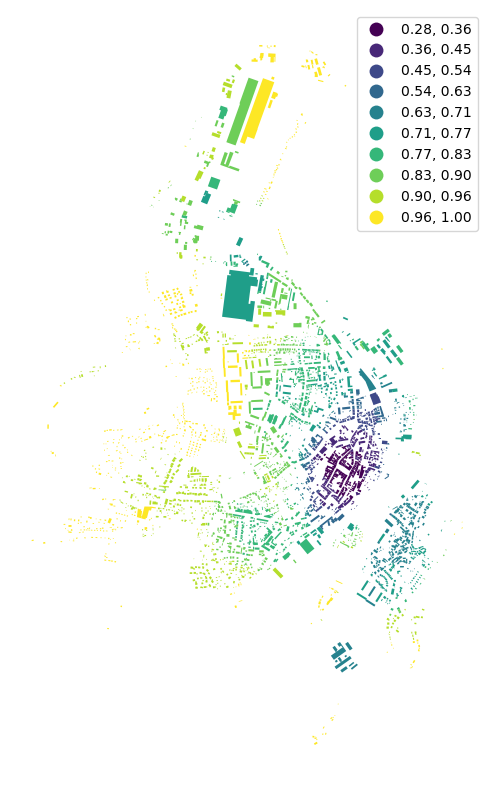

In [5]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='adjacency', legend=True, cmap='viridis', scheme='naturalbreaks', k=10)
ax.set_axis_off()
plt.show()

If we want to specify or reuse `spatial_weights`, we can generate them as Queen contiguity weights. Using `libpysal` or `momepy` (momepy will use the same libpysal method, but you don't need to import libpysal directly):

In [5]:
queen = libpysal.weights.Queen.from_dataframe(buildings,
                                              silence_warnings=True,
                                              ids='uID')
queen = momepy.sw_high(k=1, gdf=buildings, ids='uID', contiguity='queen')

In [7]:
buildings['adj2'] = momepy.BuildingAdjacency(buildings,
                                             spatial_weights_higher=dist200,
                                             unique_id='uID',
                                             spatial_weights=queen).series

Calculating adjacency: 100%|██████████| 3014/3014 [00:00<00:00, 132310.77it/s]


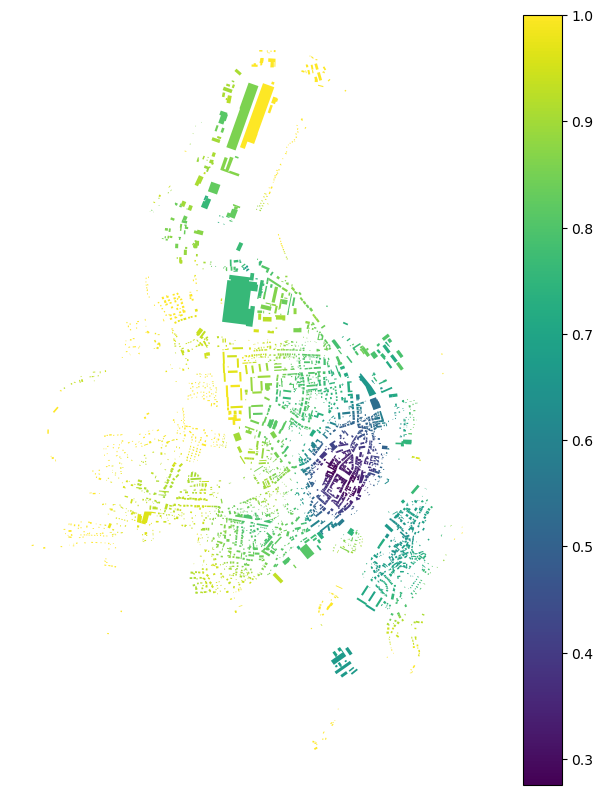

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='adj2', legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()

## Mean interbuilding distance

Mean interbuilding distance is similar to `neighbour_distance`, but it is calculated within vicinity defined by the order of contiguity.

In [6]:
queen = libpysal.weights.Queen.from_dataframe(tessellation,
                                              silence_warnings=True,
                                              ids='uID')

interblg_distance = momepy.MeanInterbuildingDistance(
    buildings, queen, 'uID')
buildings['mean_ib_dist'] = interblg_distance.series

Computing mean interbuilding distances...


100%|██████████| 3014/3014 [00:01<00:00, 2257.00it/s]


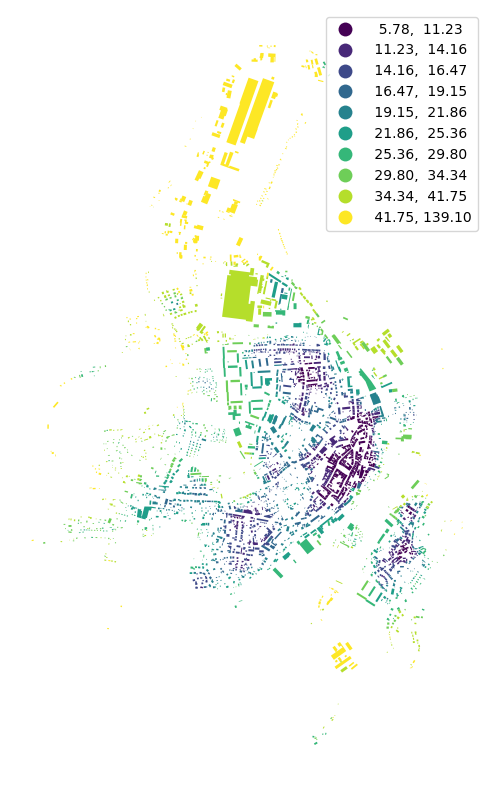

In [7]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(ax=ax, column='mean_ib_dist', scheme='quantiles', k=10, legend=True, cmap='viridis')
ax.set_axis_off()
plt.show()